# Classification with SciKit-Learn

In [32]:
# Helper function   
def load_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    # iterate through the folder tree
    for root, dirs, filenames in os.walk(folder):
        for d in dirs:
            print("Loading %s ..." % d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Read the image file
                imgFile = os.path.join(root,d, f)
                img = Image.open(imgFile)
                # Add the image to the features as a flattened numpy array
                features.append(np.array(img).ravel())
                # add the image class to the labels
                labels = np.append(labels, class_id)
            # Next class
            class_id = class_id + 1
    # Convert the features list to a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# Load the image data
data_folder = "resized_images"
features, labels, classnames = load_data(data_folder)
print("Loaded", len(features), "images of", len(classnames), "classes.")

Loading harnesses ...
Loading crampons ...
Loading rope ...
Loading insulated_jackets ...
Loading tents ...
Loading gloves ...
Loading hardshell_jackets ...
Loading carabiners ...
Loading boots ...
Loading axes ...
Loading pulleys ...
Loading helmets ...
Loaded 2122 images of 12 classes.


In [33]:
# split the image data into training and testing sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30)

print(x_train.shape)
print(y_train.shape)

(1485, 49152)
(1485,)


In [34]:
# Train a classifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Create a pipeline (in case we want to add transformations later)
img_pipeline = Pipeline([('classify', RandomForestClassifier()),
                        ])
# Use the pipeline to fit a model to the training data
print("Training model...")
image_classifier = img_pipeline.fit(x_train, y_train)

print('classifier trained!')

Training model...
classifier trained!


In [35]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np

print('Calculating classifier metrics...')
predictions = image_classifier.predict(x_test)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy:' + str(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
print(cm)

Calculating classifier metrics...
                   precision    recall  f1-score   support

        harnesses       0.85      0.94      0.89        49
         crampons       0.84      0.89      0.86        36
             rope       0.86      0.80      0.83        55
insulated_jackets       0.61      0.61      0.61        66
            tents       0.86      0.94      0.90        34
           gloves       0.86      0.99      0.92        69
hardshell_jackets       0.81      0.84      0.83       135
       carabiners       0.91      0.86      0.88        84
            boots       0.97      0.92      0.95        39
             axes       0.90      0.86      0.88        22
          pulleys       0.75      0.17      0.27        18
          helmets       0.87      0.90      0.89        30

      avg / total       0.84      0.84      0.83       637

Accuracy:0.8367346938775511

 Confusion Matrix:
[[ 46   0   0   0   1   1   0   1   0   0   0   0]
 [  0  32   0   0   1   0   0   1   0 

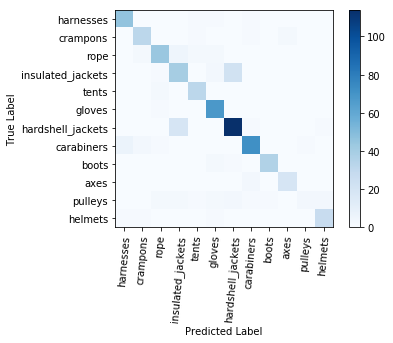

In [36]:
# Plot confusion matrix as heatmap
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

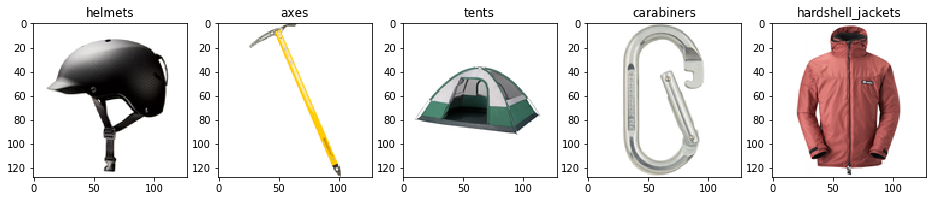

In [37]:
# function to resize new images to match training data
def resize_image(img, size=(128,128)):
    from PIL import Image
    import numpy as np
    
    # Create a white image of the target size
    newimg = Image.new("RGB", size, (255, 255, 255))
        
    # resize the source image (if not square, this will scale largest dimension to size)
    img.thumbnail(size, Image.ANTIALIAS)
    
    # paste the resized source image into the middle of the target image
    newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
    
    return newimg


# Predict class for new data
from PIL import Image, ImageOps
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

image_urls = []
image_urls.append('http://www.theworldsbestever.com/blog/wp-content/uploads/2009/11/bern-helmet.jpg')
image_urls.append('https://i.stack.imgur.com/HeliW.jpg')
image_urls.append('https://productimages.camping-gear-outlet.com/e5/62379.jpg')
image_urls.append('http://s7d1.scene7.com/is/image/MoosejawMB/MIKAJMKFMKCAPNABx1024698_zm?$product1000$')
image_urls.append('http://www.buffalosystems.co.uk/wp-content/uploads/2012/06/zoom_apline_jacket_dark_russet-2365x3286.jpg')

fig = plt.figure(figsize=(16, 12))

# Get the images and show the predicted classes
for url_idx in range(len(image_urls)):
    response = requests.get(image_urls[url_idx])
    img = Image.open(BytesIO(response.content))
    
    #pre-process the image so it matches the training set
    img = resize_image(img, (128,128))

    # Flatten the image data to correct feature format
    imgfeatures = np.array(img).ravel().reshape(1, -1)
    
    # predict the class for the new image
    class_idx =  image_classifier.predict(imgfeatures)
    class_name = classnames[int(class_idx)]
    a=fig.add_subplot(1,len(image_urls),url_idx+1)
    imgplot = plt.imshow(img)
    a.set_title(class_name)